# Lab 3: Contextual Bandit-Based News Article Recommendation

**`Course`:** Reinforcement Learning Fundamentals  
**`Student Name`:**  
**`Roll Number`:**  
**`GitHub Branch`:** firstname_U20230xxx  

# Imports and Setup

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

from rlcmab_sampler import sampler

ROLL_NUMBER = 45   # put last digits of your roll number only

np.random.seed(42)

reward_sampler = sampler(ROLL_NUMBER)


# Load Datasets

In [4]:
# Load datasets
news_df = pd.read_csv("data/news_articles.csv")
train_users = pd.read_csv("data/train_users.csv")
test_users = pd.read_csv("data/test_users.csv")

print("News:", news_df.shape)
print("Train Users:", train_users.shape)
print("Test Users:", test_users.shape)


News: (209527, 6)
Train Users: (2000, 33)
Test Users: (2000, 32)


In [21]:
# normalize categories to 4 bandit arms
def map_category(cat):

    c = str(cat).lower()

    if 'entertain' in c:
        return 'Entertainment'

    elif 'educat' in c:
        return 'Education'

    elif 'tech' in c or 'sci' in c or 'technology' in c:
        return 'Tech'

    elif 'crime' in c or 'law' in c or 'police' in c:
        return 'Crime'

    else:
        return None

news_df['mapped_category'] = news_df['category'].apply(map_category)

# remove unmapped rows
news_df = news_df.dropna(subset=['mapped_category'])

## Data Preprocessing

In this section:
- Handle missing values
- Encode categorical features
- Prepare data for user classification

In [8]:
# Handle missing values
train_users = train_users.dropna()
test_users = test_users.dropna()
news_df = news_df.dropna()

# ---------- Automatically remove ID-like columns ----------
# Any column with all unique values is an identifier
id_like_cols = []
for col in train_users.columns:
    if train_users[col].nunique() == len(train_users):
        id_like_cols.append(col)

# Never remove label
if 'label' in id_like_cols:
    id_like_cols.remove('label')

train_users = train_users.drop(columns=id_like_cols)
test_users = test_users.drop(columns=id_like_cols)

# ---------- Encode labels ----------
label_encoder = LabelEncoder()
train_users['user_label'] = label_encoder.fit_transform(train_users['label'])

# Separate features and labels
X = train_users.drop(columns=['label','user_label'])
y = train_users['user_label']

# Detect categorical vs numeric
numeric_cols = X.select_dtypes(include=['int64','float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

# One-hot encode categorical
X_encoded = pd.get_dummies(X, columns=categorical_cols)

# Prepare test set
test_users_features = pd.get_dummies(test_users)

# Align columns
X_encoded, test_users_features = X_encoded.align(test_users_features, join='left', axis=1, fill_value=0)

# Scale
scaler = StandardScaler()
X = scaler.fit_transform(X_encoded)
test_users_features = scaler.transform(test_users_features)

/var/folders/f8/fcz2jlhs7xd7mxlhlfdqg5kh0000gn/T/ipykernel_8454/1551163912.py:30: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  categorical_cols = X.select_dtypes(include=['object']).columns


## User Classification

Train a classifier to predict the user category (`User1`, `User2`, `User3`),
which serves as the **context** for the contextual bandit.


In [9]:
# 80/20 split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.95      0.87       107
           1       0.87      0.93      0.90       124
           2       1.00      0.03      0.06        30

    accuracy                           0.84       261
   macro avg       0.89      0.64      0.61       261
weighted avg       0.86      0.84      0.79       261



# `Contextual Bandit`

## Reward Sampler Initialization

The sampler is initialized using the student's roll number `i`.
Rewards are obtained using `sampler.sample(j)`.


## Arm Mapping

| Arm Index (j) | News Category | User Context |
|--------------|---------------|--------------|
| 0–3          | Entertainment, Education, Tech, Crime | User1 |
| 4–7          | Entertainment, Education, Tech, Crime | User2 |
| 8–11         | Entertainment, Education, Tech, Crime | User3 |

In [10]:
categories = ['Entertainment', 'Education', 'Tech', 'Crime']

def get_arm(context, category_index):
    return context * 4 + category_index

## Epsilon-Greedy Strategy

This section implements the epsilon-greedy contextual bandit algorithm.


In [11]:
class EpsilonGreedy:
    def __init__(self, epsilon):
        self.epsilon = epsilon
        self.q = np.zeros((3,4))
        self.n = np.zeros((3,4))

    def select_arm(self, context):
        if np.random.rand() < self.epsilon:
            return np.random.randint(4)
        return np.argmax(self.q[context])

    def update(self, context, arm, reward):
        self.n[context][arm] += 1
        self.q[context][arm] += (reward - self.q[context][arm]) / self.n[context][arm]

## Upper Confidence Bound (UCB)

This section implements the UCB strategy for contextual bandits.

In [12]:
class UCB:
    def __init__(self, c):
        self.c = c
        self.q = np.zeros((3,4))
        self.n = np.zeros((3,4))
        self.t = 1

    def select_arm(self, context):
        for a in range(4):
            if self.n[context][a] == 0:
                return a

        ucb_values = self.q[context] + self.c * np.sqrt(np.log(self.t) / self.n[context])
        return np.argmax(ucb_values)

    def update(self, context, arm, reward):
        self.t += 1
        self.n[context][arm] += 1
        self.q[context][arm] += (reward - self.q[context][arm]) / self.n[context][arm]

## SoftMax Strategy

This section implements the SoftMax strategy with temperature $ \tau = 1$.


In [13]:
class Softmax:
    def __init__(self, tau=1):
        self.tau = tau
        self.q = np.zeros((3,4))
        self.n = np.zeros((3,4))

    def select_arm(self, context):
        exp_q = np.exp(self.q[context] / self.tau)
        probs = exp_q / np.sum(exp_q)
        return np.random.choice(4, p=probs)

    def update(self, context, arm, reward):
        self.n[context][arm] += 1
        self.q[context][arm] += (reward - self.q[context][arm]) / self.n[context][arm]

## Reinforcement Learning Simulation

We simulate the bandit algorithms for $T = 10,000$ steps and record rewards.

P.S.: Change $T$ value as and if required.


In [14]:
T = 10000

def run_bandit(agent):
    rewards = []

    for t in range(T):
        context = np.random.randint(3)

        arm = agent.select_arm(context)
        j = get_arm(context, arm)

        reward = reward_sampler.sample(j)
        agent.update(context, arm, reward)

        rewards.append(reward)

    return np.cumsum(rewards) / (np.arange(T) + 1)

## Results and Analysis

This section presents:
- Average Reward vs Time
- Hyperparameter comparisons
- Observations and discussion


In [15]:
eps_agent = EpsilonGreedy(0.1)
ucb_agent = UCB(1)
soft_agent = Softmax(1)

eps_rewards = run_bandit(eps_agent)
ucb_rewards = run_bandit(ucb_agent)
soft_rewards = run_bandit(soft_agent)

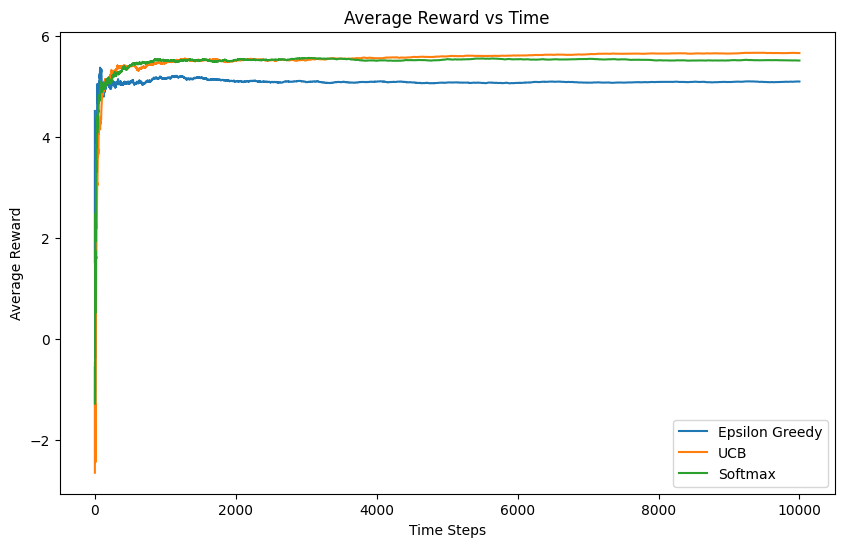

In [16]:
plt.figure(figsize=(10,6))
plt.plot(eps_rewards, label="Epsilon Greedy")
plt.plot(ucb_rewards, label="UCB")
plt.plot(soft_rewards, label="Softmax")

plt.xlabel("Time Steps")
plt.ylabel("Average Reward")
plt.title("Average Reward vs Time")
plt.legend()
plt.show()

## Final Observations

- Comparison of Epsilon-Greedy, UCB, and SoftMax
- Effect of hyperparameters
- Strengths and limitations of each approach


In [29]:
def recommend(index):

    # already preprocessed features
    row = test_users_features[index].reshape(1, -1)

    # predict user type (context)
    context = clf.predict(row)[0]

    # bandit chooses best category
    arm = np.argmax(eps_agent.q[context])
    category = categories[arm]

    # sample article from chosen category
    article = news_df[news_df['mapped_category'] == category].sample(1)

    return context, category, article['headline'].values[0]

In [28]:
print(news_df.columns)

Index(['link', 'headline', 'category', 'short_description', 'authors', 'date',
       'mapped_category'],
      dtype='str')


In [30]:
for i in range(5):
    context, category, title = recommend(i)

    print("Predicted User Type:", label_encoder.inverse_transform([context])[0])
    print("Recommended Category:", category)
    print("Article:", title)
    print("-----------")

Predicted User Type: user_2
Recommended Category: Tech
Article: Invite-a-Scientist
-----------
Predicted User Type: user_1
Recommended Category: Crime
Article: Heath Howe Tied Up Daughter To Play Video Games, Cops Say
-----------
Predicted User Type: user_1
Recommended Category: Crime
Article: Reginald Owen Sear Killed Bunnies In His Hands, Faces 2 Years In Florida Prison
-----------
Predicted User Type: user_1
Recommended Category: Crime
Article: Outside Reviews Find Tamir Rice's Shooting Justified
-----------
Predicted User Type: user_1
Recommended Category: Crime
Article: Cop Who Killed Unarmed Motorist Lying On Ground: 'He Made Me Do It'
-----------
